In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import itertools
import seaborn as sns


from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression

In [2]:
data = pd.read_csv('../data/combined_data.csv')

In [3]:
list(data)

['Unnamed: 0',
 'realSum',
 'room_type',
 'room_shared',
 'room_private',
 'person_capacity',
 'host_is_superhost',
 'multi',
 'biz',
 'cleanliness_rating',
 'guest_satisfaction_overall',
 'bedrooms',
 'dist',
 'metro_dist',
 'attr_index',
 'attr_index_norm',
 'rest_index',
 'rest_index_norm',
 'lng',
 'lat',
 'city',
 'period']

In [4]:
data['room_type']

0        Entire home/apt
1           Private room
2           Private room
3        Entire home/apt
4           Private room
              ...       
51702    Entire home/apt
51703    Entire home/apt
51704    Entire home/apt
51705    Entire home/apt
51706    Entire home/apt
Name: room_type, Length: 51707, dtype: object

In [5]:
data['city'].unique()

array(['Barcelona', 'Budapest', 'London', 'Vienna', 'Amsterdam', 'Paris',
       'Berlin', 'Lisbon', 'Athens', 'Rome'], dtype=object)

In [6]:
data['period'].unique()

array(['Weekdays', 'Weekends'], dtype=object)

# One hot encode

In [7]:
# Start by selecting only the necessary columns
filtered_data = data[['room_type', 'person_capacity', 'biz', 'bedrooms', 'dist', 'metro_dist', 'city', 'period']]

# Now apply one-hot encoding to the categorical columns 'room_type', 'city', and 'period'
one_hot_encoded_data = pd.get_dummies(filtered_data, columns=['room_type', 'city', 'period'])

# Convert all Boolean columns to integers (0 and 1) if there are any remaining after get_dummies
for col in one_hot_encoded_data.columns:
    if one_hot_encoded_data[col].dtype == bool:
        one_hot_encoded_data[col] = one_hot_encoded_data[col].astype(int)

# Since all columns are now either numeric or one-hot encoded, we can use the entire DataFrame
X = one_hot_encoded_data.values

y = data.loc[:, [
 'realSum']].values

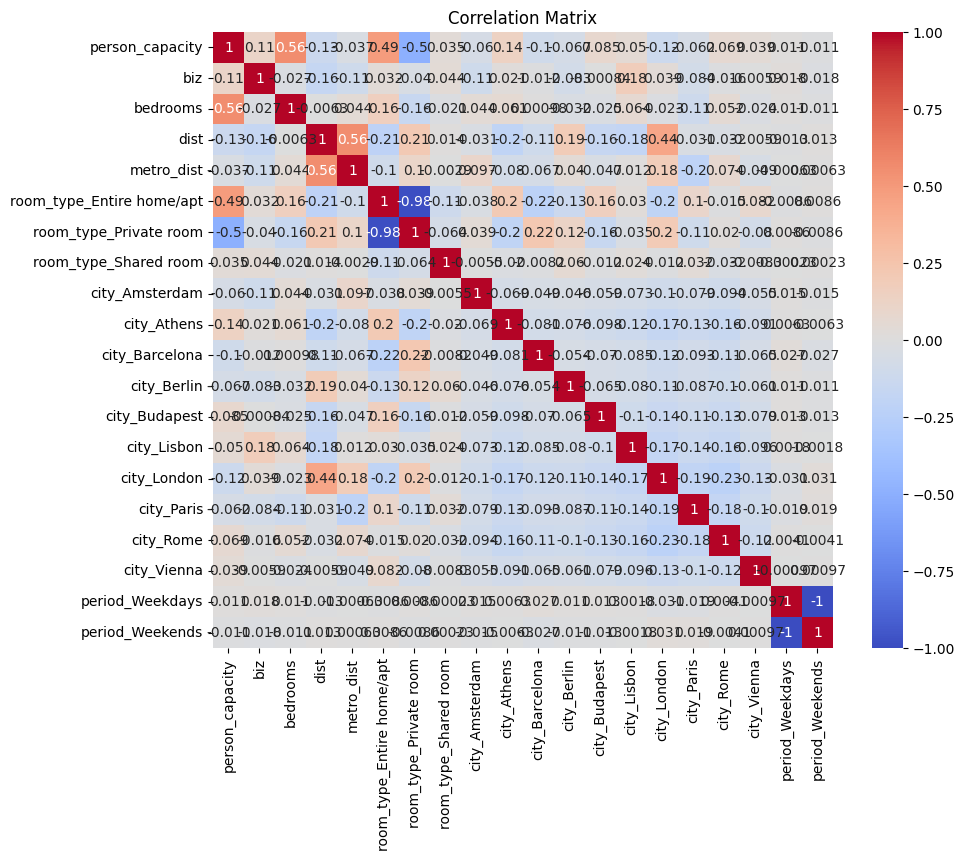

In [8]:
corr_vars = one_hot_encoded_data.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_vars, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.15, 
                                                    random_state=42)

# let's further split the training set into a training and a validation set (15%)
X_train, X_val, y_train, y_val = train_test_split(X_train, 
                                                  y_train,
                                                  test_size=X_test.shape[0] / X_train.shape[0],  
                                                  random_state=42)

# Dummy mean model

In [10]:
performances = []

In [11]:
mean_value = y_train.mean()
model_name = 'dummy'
for y,nsplit in zip([y_train, y_val, y_test],
                    ['train', 'val', 'test']):
    performance = np.sqrt(mean_squared_error(y, 
                                             [mean_value]*y.shape[0]))
    r2 = r2_score(y, [mean_value]*y.shape[0])
    performances.append({'model': model_name,
                         'split': nsplit,
                         'rmse': performance.round(4),
                         'r2': r2.round(4)})

# LM model

In [12]:
reg = LinearRegression().fit(X_train, y_train)

In [13]:
for x,y,nsplit in zip([X_train, X_val, X_test],
                    [y_train, y_val, y_test],
                    ['train', 'val', 'test']):
    preds = reg.predict(x)
    r2 = r2_score(y, preds)
    performance = np.sqrt(mean_squared_error(y, preds))
    performances.append({'model': 'linearModel1',
                         'split': nsplit,
                         'rmse': performance.round(4),
                         'r2': r2.round(4)})

# KNN model

In [14]:
for k in [3,5,10,20,30]:
    neigh = KNeighborsRegressor(n_neighbors=k)
    neigh.fit(X_train, y_train)
    #pkl.dump(neigh, file=open(f'../data/models/knn-allPred-{k}.pkl','wb')) # save the model
    for x,y,nsplit in zip([X_train, X_val, X_test],
                        [y_train, y_val, y_test],
                        ['train', 'val', 'test']):
        preds = neigh.predict(x)
        r2 = r2_score(y, preds)
        performance = np.sqrt(mean_squared_error(y, preds))
        performances.append({'model': f'knn-allPred1-{k}',
                            'split': nsplit,
                            'rmse': performance.round(4),
                            'r2': r2.round(4)})

In [15]:
perf_df = pd.DataFrame(performances)

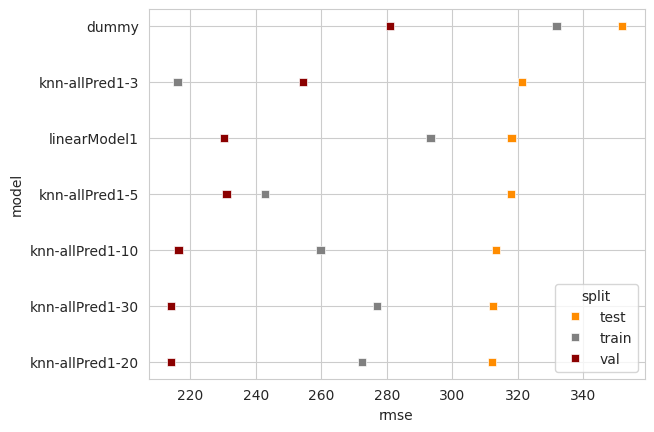

In [16]:
sns.set_style('whitegrid')
sns.scatterplot(data=perf_df.sort_values(by='rmse', ascending=False), 
                y='model', 
                x='rmse', 
                marker='s', 
                hue='split', palette=['darkorange', 'grey', 'darkred'])
plt.show()

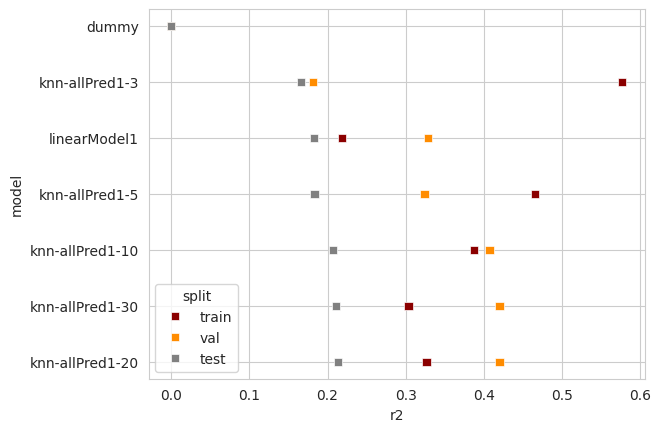

In [17]:
sns.scatterplot(data=perf_df.sort_values(by='r2', ascending=True), 
                y='model', 
                x='r2', 
                marker='s', 
                hue='split', palette=['darkred', 'darkorange', 'grey'])
plt.show()